## Lyrics Natural Language Processing Project

Scrape the lyrics of the debut albums of The Supremes ("Meet The Supremes") and Bob Dylan ("Bob Dylan"), both of which were released in 1962. Create a natural language processing model to predict whether a song's lyrics belongs to either artist.

In [561]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import re
import os, sys
from bs4 import BeautifulSoup
from itertools import chain
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from collections import Counter

In [54]:
# Setting for notebook so long strings are displayed
pd.options.display.max_colwidth = 8000

In [55]:
def make_soup(url, filename):
    """Makes BeautifulSoup object from webpage of lyrics links."""
    # Scrape webpage
    text = requests.get(url).text 
    
    # Save html text to new .txt file
    with open(filename + '.txt', 'w') as f: 
        f.write(text) 
        
    # Open .txt file and save in variable
    with open (filename + '.txt', 'r') as f: 
        text = f.read()
    
    # Make BeautifulSoup object out of text    
    soup = BeautifulSoup(text, parser='html.parser') 
    
    return soup

In [56]:
# Bob Dylan
soup = make_soup('https://www.azlyrics.com/d/dylan.html', 'linkpage_dylan')

In [57]:
# The Supremes
soup1 = make_soup('https://www.azlyrics.com/s/supremes.html', 'linkpage_supremes')

#### Get links to lyrics pages and put into a list.

In [455]:
def links_and_names(soup, regex, max_line, links_list, names_list):
    """
    Creates a list of lyrics links and a list of song names from a BeautifulSoup object.
    """
    links_list = []
    names_list = []
    
    # Find all link tags in BeautifulSoup object and extract link, add site prefix to relative link
    for l in soup.find_all('a'): 
        links_list.append('https://www.azlyrics.com' + str(l.get('href')))
    
    # Create list of links, starting from first song link on the page to number of desired song links beyond that
    links_list = links_list[34:max_line]
    
    # Extract song name from each song link
    for i in links_list:
        names_list.append(re.findall(regex, i))
    
    # Create list of song names
    names_list = [item for sublist in names_list for item in sublist]
    
    return links_list, names_list

In [538]:
# Bob Dylan
links_and_names(soup, 'dylan/(\w+)\.html', 47, 'links_dylan', 'names_dylan');

In [460]:
# The Supremes
links_and_names(soup1, 'supremes/(\w+)\.html', 45, 'links_supremes', 'names_supremes');

#### Download html of each lyrics page and save as separate files.

In [445]:
def download_pages(links_list, names_list, filename_prefix):
    """
    Saves the html text of song lyrics pages to .txt files with the song as the filename.

    """
    for i in range(len(links_list)):
        link = links_list[i]
        
        # Get the html text for each song lyrics page
        lyrics_html = requests.get(link).text
        
        # Set the filename to a desired prefix + song name, ex. 'dylan_<song name>'
        name = filename_prefix + names_list[i]
        
        # Save html text from each song lyrics page to a separate .txt file
        with open(name + '.txt', 'w') as f: 
            f.write(lyrics_html)

In [446]:
# Bob Dylan
download_pages(links_dylan, names_dylan, 'dylan_')

In [448]:
# The Supremes
download_pages(links_supremes, names_supremes, 'supremes_')

#### Extract lyrics text from page html text files and put into list

In [462]:
def lyrics_corpus(file_path, corpus_name):
    """
    Extract song lyrics text from saved html text files and put into list.
    """
    lyrics_list = []
    
    for fn in os.listdir(file_path): 
        # Turn html text into BeautifulSoup object and extract section with lyrics text
        s = open(file_path + fn).read()
        s_soup = BeautifulSoup(s, parser='html.parser')
        t = s_soup.find_all('div')[10].text
    
        # Clean text and extract lyrics
        t = re.sub('\n', ' ', t)
        l = re.findall('Lyrics\s+".+"\s{4}(.+)\s{19}S', t)
    
        # Create list with lyrics of all songs
        lyrics_list.append(l)
    
    # Flatten resulting list of lists
    corpus_name = [item for sublist in lyrics_list for item in sublist]
    
    return corpus_name

In [463]:
# Bob Dylan
lyrics_corpus('../data/dylan/', 'dylan_corpus');

In [465]:
# The Supremes
lyrics_corpus('../data/supremes/', 'supremes_corpus');

#### Bonus: Create wordclouds of each artist's song lyrics

In [622]:
def make_wordcloud(lyrics_corpus, mask_image_path):
    """
    Generate wordcloud out of a lyrics corpus masked to the silhouette of the artist.
    """
    # Flatten lyrics corpus list into a single string
    cloud_text = ''.join(chain.from_iterable(lyrics_corpus))
    
    # Choose artist image to mask the wordcloud onto
    mask_image = np.array(Image.open(mask_image_path))
    
    wordcloud = WordCloud(mask=mask_image,
                    #contour_color='black', 
                    #contour_width=3,
                    #width=500, 
                    #height=500,
                    background_color='rgba(255, 255, 255, 0)', # Makes background transparent
                    mode='RGBA',
                    min_font_size=3,
                    max_words=500,
                    stopwords=STOPWORDS, # Eliminates non-meaningful words
                    repeat=True).generate(cloud_text)
    
    # Generate and show wordcloud image
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

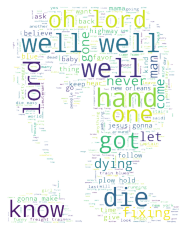

In [623]:
# Bob Dylan
make_wordcloud(dylan_corpus, '../dylan_silhouette.jpeg')

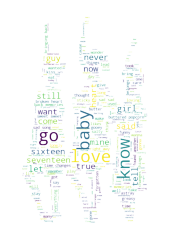

In [624]:
# The Supremes
make_wordcloud(supremes_corpus, '../supremes_silhouette.jpeg')

#### Bonus: Find 10 most common meaningful words in each artist's lyrics

In [734]:
def common_words(lyrics_corpus, num_words):
    """
    Cleans lyrics text and returns counts of the 10 most common words.
    """
    # Flatten list of lyrics into a single string
    words = ''.join(chain.from_iterable(lyrics_corpus))
    
    # Make all words lowercase
    words_lower = [x.lower() for x in words]
    
    # Remove special characters
    words_only = re.sub('\.|,|\?|[0-9]', '', words)
    
    # Remove non-meaningful words, ex. 'the'
    clean_text = [word for word in words_only.split() if word not in STOPWORDS]
    
    # Get counts of each word and return top <n> words
    return Counter(clean_text).most_common(num_words)

In [735]:
top10_dylan = common_words(dylan_corpus, 10)
top10_supremes = common_words(supremes_corpus, 10)

In [736]:
# Create DataFrames for each artist's word counts and concatenate them
top10_df = pd.concat([pd.DataFrame(top10_dylan), 
                      pd.DataFrame(top10_supremes)], 
                      keys=['Bob Dylan', 'The Supremes'])

# Rename columns
top10_df.columns = ['word', 'count']

In [732]:
top10_df

word  count
Bob Dylan    0       well     55
             1       lord     24
             2        die     23
             3         oh     16
             4        new     14
             5        got     12
             6       come     12
             7        one     12
             8      jesus     12
             9       know     11
The Supremes 0       know     29
             1       love     28
             2      heart     22
             3         go     21
             4       baby     19
             5  seventeen     18
             6       tell     17
             7        let     15
             8        guy     15
             9      never     15

#### Create x and y variables for classifier model

In [733]:
# x - Combine all lyrics into one corpus
lyrics_corpus = dylan_corpus + supremes_corpus
lyrics_corpus;

In [284]:
# y - Create list of corresponding artists to items in lyrics_corpus list
artist = ['Bob Dylan'] * 13 + ['The Supremes'] * 11

#### Split data into train and test sets

In [285]:
# Split into test and training datasets
x_train, x_test, y_train, y_test = train_test_split(lyrics_corpus, artist, random_state=1)

#### Vectorize lyrics text with CountVectorizer & normalize with TFIDF

In [364]:
# Use CountVectorizer to vectorize word counts in lyrics corpus
cv = CountVectorizer(stop_words='english', min_df=1, ngram_range=(1,1))
vec_train = cv.fit_transform(x_train)

In [533]:
# Check words and their counts - CountVectorizer has removed non-meaningful words (ex. 'the') and special characters
cv.vocabulary_;

In [367]:
# Normalize vectorized data with TFIDF
tf = TfidfTransformer()
vec_train1 = tf.fit_transform(vec_train)

In [529]:
# Make DataFrame of words and their occurence in each training set song
df_vec_train1 = pd.DataFrame(vec_train1.todense(), columns=cv.get_feature_names())
df_vec_train1.round(4);

#### Train NaiveBayes model

In [507]:
m_nb = MultinomialNB(alpha=1.0)

In [508]:
m_nb.fit(vec_train, y_train)
m_nb.score(vec_train, y_train)

1.0

In [550]:
m_nb.predict_proba(vec_train).round(4);

#### Test NaiveBayes model

In [512]:
vec_test = cv.transform(x_test)
vec_test1 = tf.transform(vec_test)

In [515]:
m_nb.predict_proba(vec_test1).round(2)
# Dylan on the left, Supremes on the right
# Interesting that Song 1 and Song 6 are about 50/50

array([[0.47, 0.53],
       [0.18, 0.82],
       [0.89, 0.11],
       [0.22, 0.78],
       [0.76, 0.24],
       [0.5 , 0.5 ]])

In [513]:
# Get list of predicted artists for each song's lyrics
m_nb.predict(vec_test1)

array(['The Supremes', 'The Supremes', 'Bob Dylan', 'The Supremes',
       'Bob Dylan', 'The Supremes'], dtype='<U12')

In [514]:
# See actual artists for each song's lyrics
y_test
# Only innacurate predication is Song 5 - model predicted Dylan with 76% certainty

['The Supremes',
 'The Supremes',
 'Bob Dylan',
 'The Supremes',
 'The Supremes',
 'The Supremes']

In [517]:
x_test[4]
# Song 5 - could it be mistaken for a Bob Dylan song?

"funny how time changes rearranges everything  for instance how could i have known that you'd be the only one for me when you wanted me i didn't want you  and time changes things its true 'cause now i want you i want you  when you used to speak to me i didn't give you a second look 'cause i already had many guys in my telephone book but one day my heart spoke your name my heart spoke your name  and time changes things its true 'cause now i want you i want you  funny how times turns the tables and left me yearning, my heart burning for instance you just past me by passed me by you didn't speak and i wanted to die now that i want you you don't want me  and time changes things, it's true you know i need you and time changes things, it's true i keep repeating, now and time changes things, it's true 'cause now i want you  it's so funny funny how time changes funny how time rearranges it's so funny it's so funny how i want you"

In [381]:
m.score(vec_test, y_test)

0.8333333333333334